In [36]:
import sys
sys.path.append('../')
sys.path.append('../../')

In [37]:
# import OFRL modules
import ofrl
from syntheticgym import SyntheticEnv
from ofrl.dataset import SyntheticDataset
from ofrl.policy import OnlineHead, ContinuousEvalHead
from ofrl.policy import ContinuousTruncatedGaussianHead as TruncatedGaussianHead
from ofrl.ope.online import (
    calc_on_policy_policy_value,
    visualize_on_policy_policy_value,
)
from ofrl.utils import MinMaxScaler, MinMaxActionScaler

# import d3rlpy algorithms
from d3rlpy.algos import RandomPolicy
# from d3rlpy.preprocessing import MinMaxScaler, MinMaxActionScaler
from ofrl.utils import MinMaxScaler, MinMaxActionScaler

# import from other libraries
import gym
import torch
from sklearn.model_selection import train_test_split

In [38]:
import pickle
from glob import glob
from tqdm import tqdm

import numpy as np
import pandas as pd
from pandas import DataFrame

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [39]:
# log directory
from pathlib import Path
Path("logs/").mkdir(exist_ok=True)

In [40]:
# standardized environment for continuous action
env = gym.make("SyntheticEnv-continuous-v0")
# for api compatibility to d3rlpy
from ofrl.utils import OldGymAPIWrapper
env_ = OldGymAPIWrapper(env)
# behavior policy
from d3rlpy.algos import SAC
from d3rlpy.models.encoders import VectorEncoderFactory
from d3rlpy.models.q_functions import MeanQFunctionFactory
from d3rlpy.online.buffers import ReplayBuffer

# model
sac = SAC(
    actor_encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    critic_encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    q_func_factory=MeanQFunctionFactory(),
    use_gpu=torch.cuda.is_available(),
    action_scaler=MinMaxActionScaler(
        minimum=env_.action_space.low,   # 0.1
        maximum=env_.action_space.high,  # 10
    ),
)
# setup replay buffer
buffer = ReplayBuffer(
    maxlen=10000,
    env=env_,
)

In [ ]:
# start training
# skip if there is a pre-trained model
sac.fit_online(
    env_,
    buffer,
    eval_env=env_,
    n_steps=1000,
    n_steps_per_epoch=10,
    update_start_step=10,
    # n_steps=100000,
    # n_steps_per_epoch=1000,
    # update_start_step=1000,
)
# save model
sac.save_model("d3rlpy_logs/sac.pt")
# reload model
sac.build_with_env(env_)
sac.load_model("d3rlpy_logs/sac.pt")

In [42]:
from d3rlpy.dataset import MDPDataset
from d3rlpy.algos import CQL

In [43]:
# import ope modules from OFRL
from ofrl.ope import CreateOPEInput
from ofrl.ope import OffPolicyEvaluation as OPE
# basic estimators
from ofrl.ope import ContinuousDirectMethod as DM
from ofrl.ope import ContinuousTrajectoryWiseImportanceSampling as TIS
from ofrl.ope import ContinuousPerDecisionImportanceSampling as PDIS
from ofrl.ope import ContinuousDoublyRobust as DR
# self normalized estimators
from ofrl.ope import ContinuousSelfNormalizedTrajectoryWiseImportanceSampling as SNTIS
from ofrl.ope import ContinuousSelfNormalizedPerDecisionImportanceSampling as SNPDIS
from ofrl.ope import ContinuousSelfNormalizedDoublyRobust as SNDR
# marginal estimators
from ofrl.ope import ContinuousStateActionMarginalImportanceSampling as SAMIS
from ofrl.ope import ContinuousStateActionMarginalDoublyRobust as SAMDR
from ofrl.ope import ContinuousStateMarginalImportanceSampling as SMIS
from ofrl.ope import ContinuousStateMarginalDoublyRobust as SMDR
from ofrl.ope import ContinuousStateActionMarginalSelfNormalizedImportanceSampling as SAMSNIS
from ofrl.ope import ContinuousStateActionMarginalSelfNormalizedDoublyRobust as SAMSNDR
from ofrl.ope import ContinuousStateMarginalSelfNormalizedImportanceSampling as SMSNIS
from ofrl.ope import ContinuousStateMarginalSelfNormalizedDoublyRobust as SMSNDR
# double reinforcement learning estimators
from ofrl.ope import ContinuousDoubleReinforcementLearning as DRL

In [44]:
basic_estimators = [DM(), TIS(), PDIS(), DR(), SNTIS(), SNPDIS(), SNDR()]
state_marginal_estimators = [SMIS(), SMDR(), SMSNIS(), SMSNDR()]
state_action_marginal_estimators = [SAMIS(), SAMDR(), SAMSNIS(), SAMSNDR()]
drl_estimators = [DRL()]
all_estimators = basic_estimators + state_marginal_estimators + state_action_marginal_estimators + drl_estimators

basic_estimators_name = ["dm", "tis", "pdis", "dr", "sntis", "snpdis", "sndr"]
state_marginal_estimators_name = ["sm_is", "sm_dr", "sm_snis", "sm_sndr"]
state_action_marginal_estimators_name = ["sam_is", "sam_dr", "sam_snis", "sam_sndr"]
drl_estimators_name = ["drl"]

In [45]:
n_trajectories_list = [100, 200, 400, 800, 1600]
# n_trajectories_list = [100, 200, 400, 800, 1600, 3200, 6400, 12800, 25600, 51200]
random_state_list = [10, 20, 30, 40, 50]
# random_state_list = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
bias_df_list = []
variance_df_list = []


In [ ]:

for n_trajectories in n_trajectories_list:
    # se_list = []
    for random_state in random_state_list:
    
        behavior_policy = TruncatedGaussianHead(
            sac, 
            minimum=env.action_space.low,
            maximum=env.action_space.high,
            sigma=np.array([1.0]),
            name="sac_sigma_1.0",
            random_state=random_state,
        )

        # initialize dataset class
        dataset = SyntheticDataset(
            env=env,
            max_episode_steps=env.step_per_episode,
        )

        # collect logged data by a behavior policy
        # skip if there is a preserved logged dataset
        train_logged_dataset = dataset.obtain_episodes(
            behavior_policies=behavior_policy,
            # n_trajectories=10000, 
            n_trajectories=n_trajectories, 
            obtain_info=False,
            random_state=random_state,
        )
        test_logged_dataset = dataset.obtain_episodes(
            behavior_policies=behavior_policy,
            # n_trajectories=10000, 
            n_trajectories=n_trajectories, 
            obtain_info=False,
            random_state=random_state + 1,
        )

        # with open("logs/train_dataset_continuous_sac.pkl", "wb") as f:
        # pickle.dump(train_logged_dataset, f)
        # with open("logs/test_dataset_continuous_sac.pkl", "wb") as f:
        # pickle.dump(test_logged_dataset, f)

        # with open("logs/train_dataset_continuous_sac.pkl", "rb") as f:
        # train_logged_dataset = pickle.load(f)
        # with open("logs/test_dataset_continuous_sac.pkl", "rb") as f:
        # test_logged_dataset = pickle.load(f)

        # transform offline dataset for d3rlpy
        offlinerl_dataset = MDPDataset(
            observations=train_logged_dataset["state"],
            actions=train_logged_dataset["action"],
            rewards=train_logged_dataset["reward"],
            terminals=train_logged_dataset["done"],
            episode_terminals=train_logged_dataset["done"],
            discrete_action=False,
        )
        train_episodes, test_episodes = train_test_split(offlinerl_dataset, test_size=0.2, random_state=random_state)

        # Use Conservative Q-Learning policy
        cql = CQL(
            actor_encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
            critic_encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
            q_func_factory=MeanQFunctionFactory(),
            use_gpu=torch.cuda.is_available(),
            action_scaler=MinMaxActionScaler(
                minimum=env_.action_space.low,  # minimum value that policy can take
                maximum=env_.action_space.high,  # maximum value that policy can take
            )
        )

        cql.fit(
            train_episodes,
            eval_episodes=test_episodes,
            n_steps=10000,
            # n_steps=10000,
            scorers={},
        )

        # # save model
        # cql.save_model("d3rlpy_logs/cql_continuous.pt")

        # # reload model
        # cql.build_with_env(env)
        # cql.load_model("d3rlpy_logs/cql_continuous.pt")

        # define evaluation policies (should be deterministic policy)
        cql_ = ContinuousEvalHead(
            base_policy=cql,
            name="cql",
        )
        sac_ = ContinuousEvalHead(
            base_policy=sac, 
            name="sac", 
        )
        evaluation_policies = [cql_, sac_]
        
        # first, prepare OPE inputs
        prep = CreateOPEInput(
            env=env,
            model_args={
                "fqe": {
                    "encoder_factory": VectorEncoderFactory(hidden_units=[30, 30]),
                    "q_func_factory": MeanQFunctionFactory(),
                    "learning_rate": 1e-4,
                    "use_gpu": torch.cuda.is_available(),
                },
            },
            state_scaler=MinMaxScaler(
                minimum=test_logged_dataset["state"].min(axis=0),
                maximum=test_logged_dataset["state"].max(axis=0),
            ),
            action_scaler=MinMaxActionScaler(
                minimum=env.action_space.low,  # minimum value that policy can take
                maximum=env.action_space.high,  # maximum value that policy can take
            ),
            gamma=0.95,
            sigma=0.1,
            device="cuda:0" if torch.cuda.is_available() else "cpu",
        )

        # takes time
        input_dict = prep.obtain_whole_inputs(
            logged_dataset=test_logged_dataset,
            evaluation_policies=evaluation_policies,
            require_value_prediction=True,
            require_weight_prediction=True,
            n_trajectories_on_policy_evaluation=100,
            random_state=random_state,
        )

        # with open("logs/ope_input_dict_continuous_zoo.pkl", "wb") as f:
        # pickle.dump(input_dict, f)

        # with open("logs/ope_input_dict_continuous_zoo.pkl", "rb") as f:
        # input_dict = pickle.load(f)

        ope = OPE(
            logged_dataset=test_logged_dataset,
            ope_estimators=all_estimators,
            action_scaler=MinMaxActionScaler(
                minimum=env.action_space.low,  # minimum value that policy can take
                maximum=env.action_space.high,  # maximum value that policy can take
            ),
            sigma=0.1,
        )

        policy_value_dict = ope.estimate_policy_value(
            input_dict=input_dict,
        )
        
        tmp_cql = DataFrame(policy_value_dict)['cql']
        cql_data = pd.concat([cql_data, tmp_cql], axis=1)
        # tmp_sac = DataFrame(policy_value_dict)['sac']
        # sac_data = pd.concat([sac_data, tmp_sac], axis=1)
        
        
    bias = abs(cql_data.mean(axis=1) - cql_data.mean(axis=1)['on_policy'])
    variance = cql_data.var(axis=1)

    bias_df = DataFrame(DataFrame(bias).stack())\
        .reset_index(1).rename(columns={"level_1": "est", 0: "bias"})
    bias_df["n_trajectories"] = n_trajectories
    bias_df_list.append(bias_df)
    variance_df = DataFrame(DataFrame(variance).stack())\
        .reset_index(1).rename(columns={"level_1": "est", 0: "bias"})
    variance_df["n_trajectories"] = n_trajectories
    variance_df_list.append(variance_df)


    # bias_df[n_trajectories] = bias
    # variance_df[n_trajectories] = variance

# aggregate all results 
bias_result_df = pd.concat(bias_df_list).reset_index(level=0)
variance_result_df = pd.concat(variance_df_list).reset_index(level=0)

In [ ]:
bias_result_df

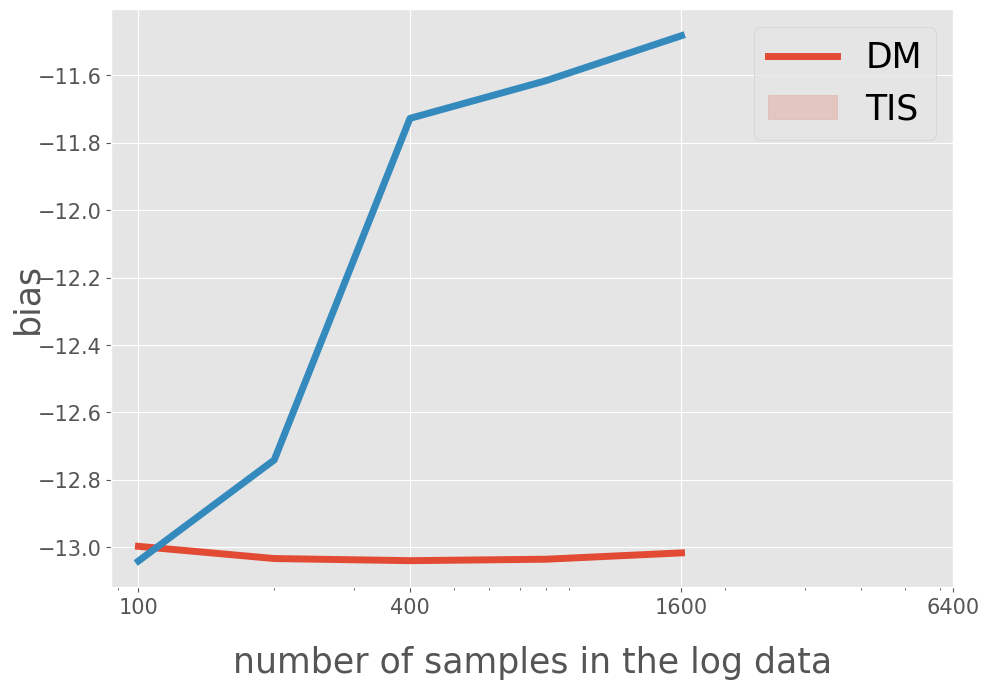

In [ ]:
# figure configs
# query = "(est == 'DM' or est == 'IPS') and num_data <= 6400"
xlabels = [100, 400, 1600, 6400]

plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10, 7), tight_layout=True)
sns.lineplot(
    linewidth=5,
    dashes=False,
    legend=False,
    x="n_trajectories",
    y="bias",
    hue="index",
    ax=ax,
    data=bias_result_df.query("(index == 'dm' or index == 'tis')")
,
)
# title and legend
ax.legend(["DM", "TIS"], loc="upper right", fontsize=25)
# yaxis
# ax.set_yscale("log")
ax.set_ylabel("bias", fontsize=25)
ax.tick_params(axis="y", labelsize=15)
ax.yaxis.set_label_coords(-0.08, 0.5)
# xaxis
ax.set_xscale("log")
ax.set_xlabel("number of trajectories", fontsize=25)
ax.set_xticks(xlabels)
ax.set_xticklabels(xlabels, fontsize=15)
ax.xaxis.set_label_coords(0.5, -0.1)

In [ ]:
variance_result_df

In [ ]:
# figure configs
# query = "(est == 'DM' or est == 'IPS') and num_data <= 6400"
xlabels = [100, 400, 1600, 6400]

plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10, 7), tight_layout=True)
sns.lineplot(
    linewidth=5,
    dashes=False,
    legend=False,
    x="n_trajectories",
    y="variance",
    hue="index",
    ax=ax,
    data=variance_result_df.query("(index == 'dm' or index == 'tis')")
,
)
# title and legend
ax.legend(["DM", "TIS"], loc="upper right", fontsize=25)
# yaxis
# ax.set_yscale("log")
ax.set_ylabel("variance", fontsize=25)
ax.tick_params(axis="y", labelsize=15)
ax.yaxis.set_label_coords(-0.08, 0.5)
# xaxis
ax.set_xscale("log")
ax.set_xlabel("number of trajectories", fontsize=25)
ax.set_xticks(xlabels)
ax.set_xticklabels(xlabels, fontsize=15)
ax.xaxis.set_label_coords(0.5, -0.1)

,index,est,bias,n_trajectories
1,dm,0,-12.996905,100
2,tis,0,-13.040242,100
18,dm,0,-13.033082,200
19,tis,0,-12.740832,200
35,dm,0,-13.039381,400
36,tis,0,-11.728284,400
52,dm,0,-13.035099,800
53,tis,0,-11.616714,800
69,dm,0,-13.016320,1600
70,tis,0,-11.483167,1600


In [1]:
# figure configs
# query = "(est == 'DM' or est == 'IPS') and num_data <= 6400"
xlabels = [100, 400, 1600, 6400]

plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10, 7), tight_layout=True)
sns.lineplot(
    linewidth=5,
    dashes=False,
    legend=False,
    x="n_trajectories",
    y="variance",
    hue="index",
    ax=ax,
    data=variance_result_df.query("(index == 'tis' or index == 'tdis')")
,
)
# title and legend
ax.legend(["TIS", "TDIS"], loc="upper right", fontsize=25)
# yaxis
# ax.set_yscale("log")
ax.set_ylabel("variance", fontsize=25)
ax.tick_params(axis="y", labelsize=15)
ax.yaxis.set_label_coords(-0.08, 0.5)
# xaxis
ax.set_xscale("log")
ax.set_xlabel("number of trajectories", fontsize=25)
ax.set_xticks(xlabels)
ax.set_xticklabels(xlabels, fontsize=15)
ax.xaxis.set_label_coords(0.5, -0.1)

NameError: name 'plt' is not defined